# Proyek Klasifikasi Gambar: 10 Jenis Hewan (Dataset Animals-10)

- Nama: Bimoseno Kuma
- Email: kuma24@student.ub.ac.id
- ID Dicoding: kukuma

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install split-folders --quiet
!pip install tensorflowjs --quiet
from google.colab import files, drive
import os
import sys
import shutil
import zipfile
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import subprocess
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import splitfolders
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
Mounted at /content/drive


In [2]:
print("Silakan upload file kaggle.json Anda:")
files.upload()

# Membuat direktori .kaggle dan memindahkan file kaggle.json ke sana
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

print("\nFile kaggle.json berhasil dikonfigurasi.")

Silakan upload file kaggle.json Anda:


Saving kaggle.json to kaggle.json

File kaggle.json berhasil dikonfigurasi.


### Data Loading

In [3]:
# Direktori dataset akan dibuat di /content/
dataset_dir = '/content/raw-img'

if os.path.exists(dataset_dir):
    print("Dataset 'raw-img' sudah ada. Melewatkan proses unduh.")
else:
    print("Dataset belum ada. Memulai proses unduh dari Kaggle...")
    # Perintah kaggle untuk mengunduh dan unzip langsung ke direktori kerja saat ini (/content/)
    !kaggle datasets download -d alessiocorrado99/animals10 --unzip
    print("\nDataset berhasil diunduh dan diekstrak.")

# Verifikasi isi folder
print("\nIsi direktori kerja saat ini (/content/):")
!ls -lh

Dataset belum ada. Memulai proses unduh dari Kaggle...
Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 98% 574M/586M [00:06<00:00, 171MB/s]
100% 586M/586M [00:06<00:00, 90.6MB/s]

Dataset berhasil diunduh dan diekstrak.

Isi direktori kerja saat ini (/content/):
total 16K
drwx------  5 root root 4.0K Jun 27 05:11 drive
drwxr-xr-x 12 root root 4.0K Jun 27 05:12 raw-img
drwxr-xr-x  1 root root 4.0K Jun 25 13:36 sample_data
-rw-r--r--  1 root root  380 Jun 27 05:12 translate.py


### Data Preprocessing

#### Split Dataset

In [4]:
# Path input dan output
input_folder = '/content/raw-img'
output_folder = '/content/dataset_split'

# Check if input folder exists
if not os.path.exists(input_folder):
    print(f"Error: Folder '{input_folder}' tidak ditemukan!")
    print("Pastikan dataset sudah didownload dan diekstrak.")
    sys.exit(1)

# Hapus folder output jika sudah ada untuk memastikan kebersihan
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
    print(f"Removed existing {output_folder}")

# Lakukan pembagian dengan rasio 80:10:10
print("\nSplitting dataset into train/val/test...")
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .1, .1))

print(f"Dataset berhasil dibagi ke dalam folder: {output_folder}")
print(f"Isi folder output: {os.listdir(output_folder)}")


Splitting dataset into train/val/test...


Copying files: 26179 files [00:04, 6490.87 files/s]

Dataset berhasil dibagi ke dalam folder: /content/dataset_split
Isi folder output: ['train', 'val', 'test']


In [5]:
# --- Membangun Pipeline tf.data yang Efisien ---
BATCH_SIZE = 32
IMG_WIDTH, IMG_HEIGHT = 150, 150
AUTOTUNE = tf.data.AUTOTUNE

# Konversi path ke objek Pathlib untuk kemudahan
data_dir = pathlib.Path(output_folder)
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

# Buat dataset dari direktori
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

# Dapatkan nama kelas
class_names = train_dataset.class_names
print("\nNama kelas yang ditemukan:", class_names)

# Optimalkan dataset dengan cache dan prefetch
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("\n✓ Data pipeline sederhana (tanpa normalisasi/augmentasi) telah dibuat.")

Found 20938 files belonging to 10 classes.
Found 2614 files belonging to 10 classes.
Found 2627 files belonging to 10 classes.

Nama kelas yang ditemukan: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

✓ Data pipeline sederhana (tanpa normalisasi/augmentasi) telah dibuat.


## Modelling

In [6]:
# Pastikan Anda sudah mengatur device
device = '/GPU:0' if len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
print(f"Using device: {device}")

with tf.device(device):
    # 1. base model (EfficientNetB0) untuk dimasukkan ke Sequential
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
    )

    # Bekukan base model
    base_model.trainable = False

    # 2. Bangun model menggunakan tf.keras.Sequential
    model = Sequential([
        # Lapisan untuk augmentasi data
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        base_model,

        # Tambahkan layer Conv2D kustom
        Conv2D(64, (3, 3), activation='relu', padding='same'),

        # Tambahkan layer Pooling kustom
        MaxPooling2D(pool_size=(2, 2)),
        # --------------------------------------------------

        # Flatten output untuk disambungkan ke Dense layer
        Flatten(),

        # Classifier Head
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax')
    ], name="sequential_transfer_learning_model")

    # 3. Kompilasi model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

print("\nModel Summary (Sequential with Transfer Learning):")
model.summary()

Using device: /GPU:0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Model Summary (Sequential with Transfer Learning):


Model: "sequential_transfer_learning_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

## Evaluasi dan Visualisasi

In [7]:
# Definisikan callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

In [8]:
# Tentukan jumlah epoch
EPOCHS = 50

print(f"\nStarting training for {EPOCHS} epochs...")

# Latih model menggunakan tf.data.Dataset
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)



Starting training for 50 epochs...
Epoch 1/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6576 - loss: 1.0902
Epoch 1: val_accuracy improved from -inf to 0.94185, saving model to best_model.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 62s 70ms/step - accuracy: 0.6578 - loss: 1.0896 - val_accuracy: 0.9419 - val_loss: 0.1873 - learning_rate: 1.0000e-04
Epoch 2/50
654/655 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8628 - loss: 0.4269
Epoch 2: val_accuracy improved from 0.94185 to 0.94682, saving model to best_model.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.8628 - loss: 0.4268 - val_accuracy: 0.9468 - val_loss: 0.1655 - learning_rate: 1.0000e-04
Epoch 3/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8888 - loss: 0.3443
Epoch 3: val_accuracy improved from 0.94682 to 0.95180, saving model to best_model.keras
655/655 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.8888 - loss: 0.3443 - val_accuracy: 0.9518 - val_loss: 0.1594 - learning_rate: 1.0000e-0


Plotting training history...


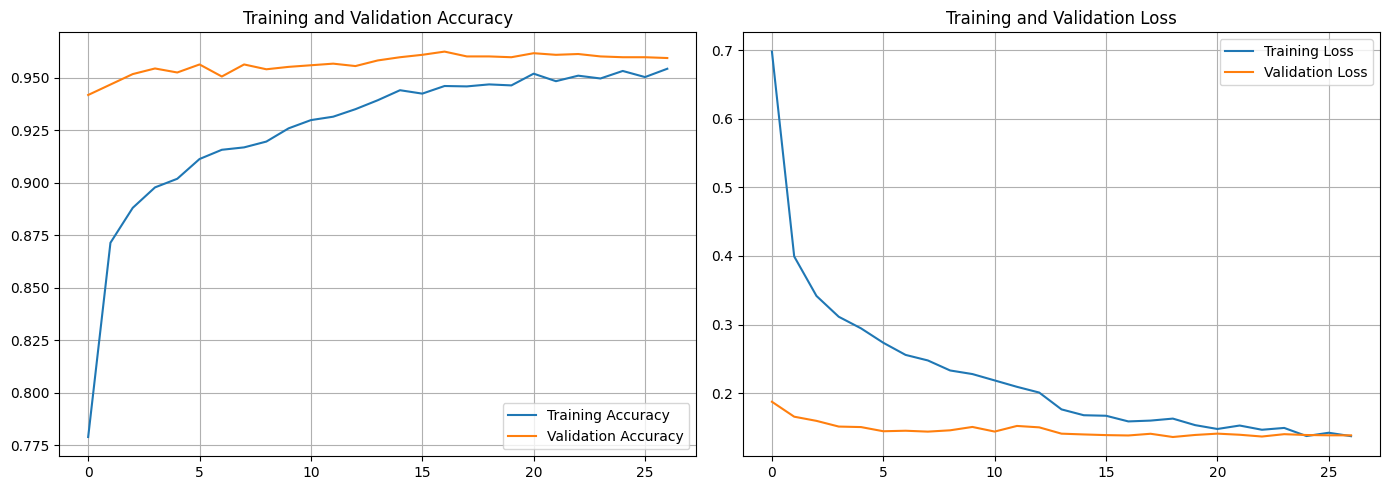

In [9]:
# Plot akurasi dan loss
print("\nPlotting training history...")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


Mengevaluasi model pada data tes...
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9705 - loss: 0.1137

Akurasi pada data tes: 96.57%
Loss pada data tes: 0.1470

Generating predictions...
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step

Classification Report:
              precision    recall  f1-score   support

        cane       0.97      0.97      0.97       487
     cavallo       0.95      0.97      0.96       263
    elefante       0.95      0.99      0.97       146
    farfalla       0.99      0.96      0.97       212
     gallina       0.98      0.98      0.98       311
       gatto       0.95      0.96      0.96       168
       mucca       0.92      0.93      0.92       188
      pecora       0.93      0.88      0.91       182
       ragno       0.98      0.98      0.98       483
  scoiattolo       0.98      0.98      0.98       187

    accuracy                           0.97      2627
   macro avg       0.96      0.96      0.96      2627
weighted avg       0.97      0.97   

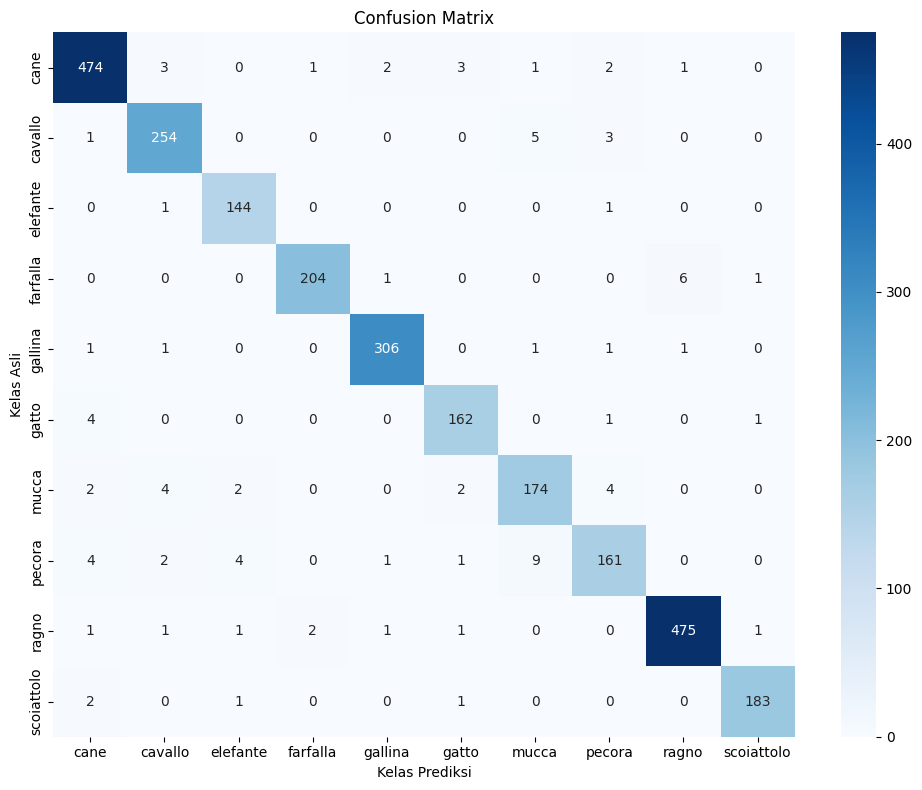

In [10]:
# --- Evaluasi pada data tes menggunakan test_dataset ---
print("\nMengevaluasi model pada data tes...")
test_loss, test_acc = model.evaluate(test_dataset, verbose=1)

print(f'\nAkurasi pada data tes: {test_acc*100:.2f}%')
print(f'Loss pada data tes: {test_loss:.4f}')

# --- Prediksi untuk classification report dan confusion matrix ---
print("\nGenerating predictions...")
Y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(Y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Laporan Klasifikasi
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Kelas Asli')
plt.xlabel('Kelas Prediksi')
plt.tight_layout()
plt.show()


## Konversi Model

In [ ]:
# --- Langkah 1: Buat arsitektur model inferensi (tanpa augmentasi) ---
print("Membangun arsitektur model inferensi...")

# Kita buat ulang arsitektur TANPA lapisan augmentasi di awal
inference_model = Sequential([
    # Tidak ada lapisan augmentasi di sini
    EfficientNetB0(
        weights=None, # Bobot akan dimuat dari file, bukan diunduh
        include_top=False,
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
    ),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
], name="inference_model")

# --- Langkah 2: Muat bobot terbaik ke model inferensi ---
print("\nMemuat bobot terbaik dari 'best_model.keras'...")
inference_model.load_weights('best_model.keras')
print("✓ Bobot berhasil dimuat.")

# --- Langkah 3: Ekspor 'inference_model' yang bersih ---
os.makedirs('saved_model', exist_ok=True)
os.makedirs('tflite', exist_ok=True)
os.makedirs('tfjs_model', exist_ok=True)

SAVED_MODEL_PATH = 'saved_model'
TFLITE_DIR = 'tflite'
TFJS_MODEL_PATH = 'tfjs_model'

# 1. Ekspor ke format SavedModel
print(f"\nMengekspor model inferensi ke '{SAVED_MODEL_PATH}'...")
inference_model.export(SAVED_MODEL_PATH)
print("✓ Model SavedModel berhasil diekspor.")

# 2. Konversi ke format TF-Lite
print("\nMemulai konversi ke format TensorFlow Lite...")
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
tflite_model = converter.convert()
tflite_model_path = os.path.join(TFLITE_DIR, 'model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print(f"✓ Model TF-Lite berhasil disimpan di: {tflite_model_path}")

# Membuat label.txt
label_path = os.path.join(TFLITE_DIR, 'label.txt')
with open(label_path, 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")
print(f"✓ File label.txt berhasil dibuat di: {label_path}")

# 3. Konversi ke format TFJS
print("\nMemulai konversi ke format TensorFlow.js...")
!tensorflowjs_converter --input_format=tf_saved_model {SAVED_MODEL_PATH} {TFJS_MODEL_PATH}
print(f"\n✓ Proses konversi TFJS selesai. Periksa folder '{TFJS_MODEL_PATH}'.")

## Inference (Optional)

In [12]:
print("\nPerforming inference test...")

SAVED_MODEL_PATH_FOR_INFERENCE = 'saved_model'

try:
    loaded_model_layer = tf.keras.layers.TFSMLayer(SAVED_MODEL_PATH_FOR_INFERENCE, call_endpoint='serving_default')

    inference_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    inference_output = loaded_model_layer(inference_input)

    loaded_model = Model(inputs=inference_input, outputs=inference_output)

    print("✓ SavedModel (no augmentation) loaded as TFSMLayer successfully for inference.")

except Exception as e:
    print(f"Error loading SavedModel (no augmentation) as TFSMLayer: {e}")
    sys.exit("Failed to load the SavedModel for inference.")

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # HAPUS BARIS INI: img_array /= 255.0  # Normalisasi
    return img_array

# Pilih kelas acak dan gambar acak dari data tes
random_class = random.choice(class_names)
random_class_path = os.path.join(test_dir, random_class)
random_image_name = random.choice(os.listdir(random_class_path))
test_image_path = os.path.join(random_class_path, random_image_name)

print(f"Testing inference on a random image from class: '{random_class}'")
print(f"Image path: {test_image_path}")

# Process image and make prediction using the loaded model
processed_img = load_and_preprocess_image(test_image_path)
prediction_output = loaded_model.predict(processed_img)

# The output of TFSMLayer is a dictionary. Access the prediction tensor.
# The key is typically 'output_0' for a single output model.
if isinstance(prediction_output, dict) and 'output_0' in prediction_output:
    prediction = prediction_output['output_0']
elif isinstance(prediction_output, tf.Tensor):
     prediction = prediction_output
else:
    print(f"Unexpected prediction output format: {type(prediction_output)}")
    print(f"Output keys: {prediction_output.keys() if isinstance(prediction_output, dict) else 'N/A'}")
    sys.exit("Could not extract prediction tensor from model output.")


predicted_class_index = np.argmax(prediction)
predicted_class_name = class_names[predicted_class_index]
confidence = np.max(prediction) * 100

print(f"\nPrediction:")
print(f"  Predicted class: {predicted_class_name}")
print(f"  Confidence: {confidence:.2f}%")
print(f"  Actual class: {random_class}")


Performing inference test...
✓ SavedModel (no augmentation) loaded as TFSMLayer successfully for inference.
Testing inference on a random image from class: 'elefante'
Image path: /content/dataset_split/test/elefante/OIP-pyIIoviU1TDqzyxIoZ5wVwHaFv.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step

Prediction:
  Predicted class: elefante
  Confidence: 99.85%
  Actual class: elefante


In [13]:
print("\n" + "="*70)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"Total parameters: {model.count_params():,}")

print(f"Final test accuracy: {test_acc*100:.2f}%")
print(f"Device used: {device}")
print("\nModel saved in:")
print("- saved_model/model (SavedModel format)")
print("- tflite/model.tflite (TensorFlow Lite)")
print("- tfjs_model/ (TensorFlow.js)")


TRAINING COMPLETED SUCCESSFULLY!
Total parameters: 4,923,629
Final test accuracy: 96.57%
Device used: /GPU:0

Model saved in:
- saved_model/model (SavedModel format)
- tflite/model.tflite (TensorFlow Lite)
- tfjs_model/ (TensorFlow.js)
